In [1]:
import sys
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import gc

from augmentation import augment
from data_generator import DOTASequence, SegmentationSequence
import model_builder
import accuracy

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2080, compute capability 7.5


In [2]:
annot_path = 'data/train/annotations' #Path to directory of annotations
images_path = 'data/train/images' #Path to directory of images
generator = DOTASequence(images_path, annot_path, augmenter = augment)

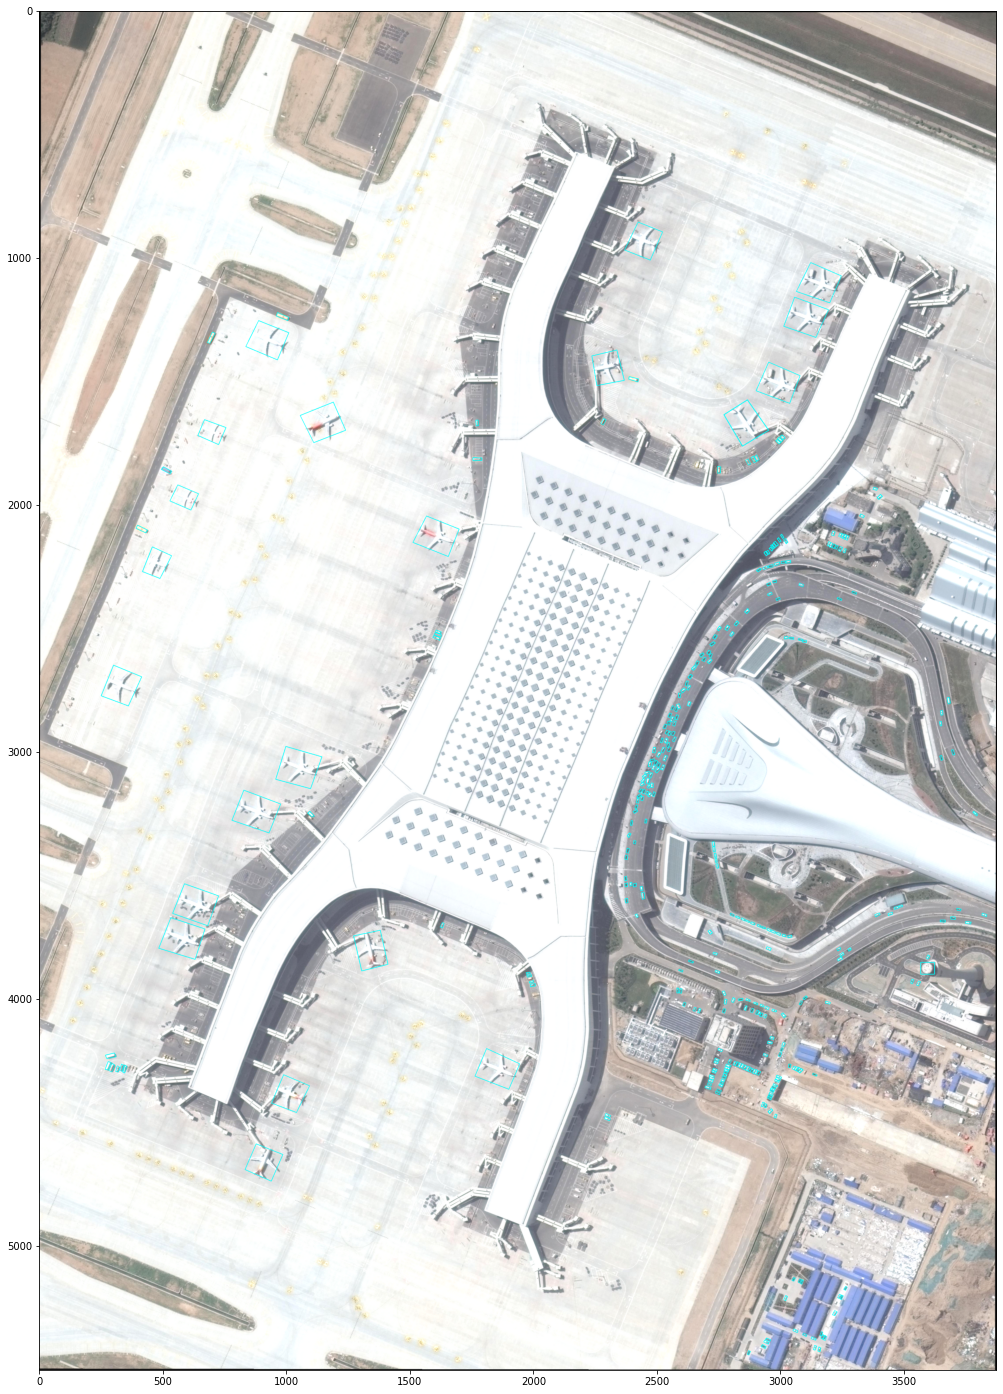

In [3]:
idx = 0
imgbatch, annotbatch = generator[idx]
img = imgbatch[0]
annot = annotbatch[0]

plt.figure(figsize = (25,25))

for line in annot:
    p1 = int(line[0]), int(line[1])
    p2 = int(line[2]), int(line[3])
    p3 = int(line[4]), int(line[5])
    p4 = int(line[6]), int(line[7])
    
    color = (0,255,255)
    cv2.line(img, p1, p2, color,2)
    cv2.line(img, p2, p3, color,2)
    cv2.line(img, p3, p4, color,2)
    cv2.line(img, p4, p1, color,2)

plt.imshow(img)

P0000
P0001


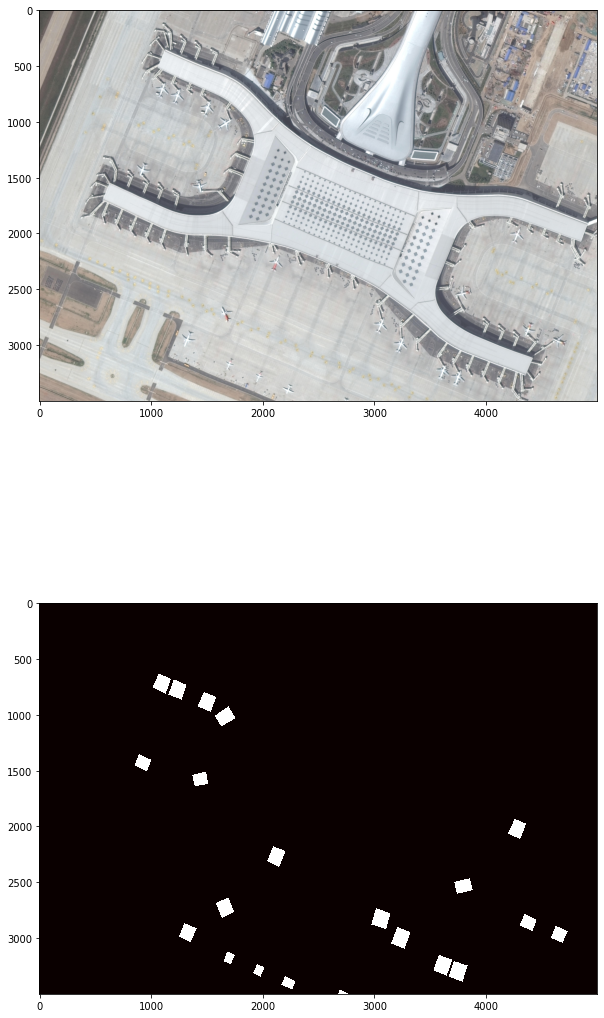

In [4]:
seg_generator = SegmentationSequence(images_path, annot_path, augmenter = augment, output_img_size=(5000, 3500))
img, mask = seg_generator[0]
img = img[0].astype(np.uint8)
mask = mask[0]
fig = plt.figure(figsize=(10,20))
fig.add_subplot(2, 1, 1)
plt.imshow(img)
fig.add_subplot(2, 1, 2)
plt.imshow(mask[:,:,0], cmap="hot", interpolation="nearest")

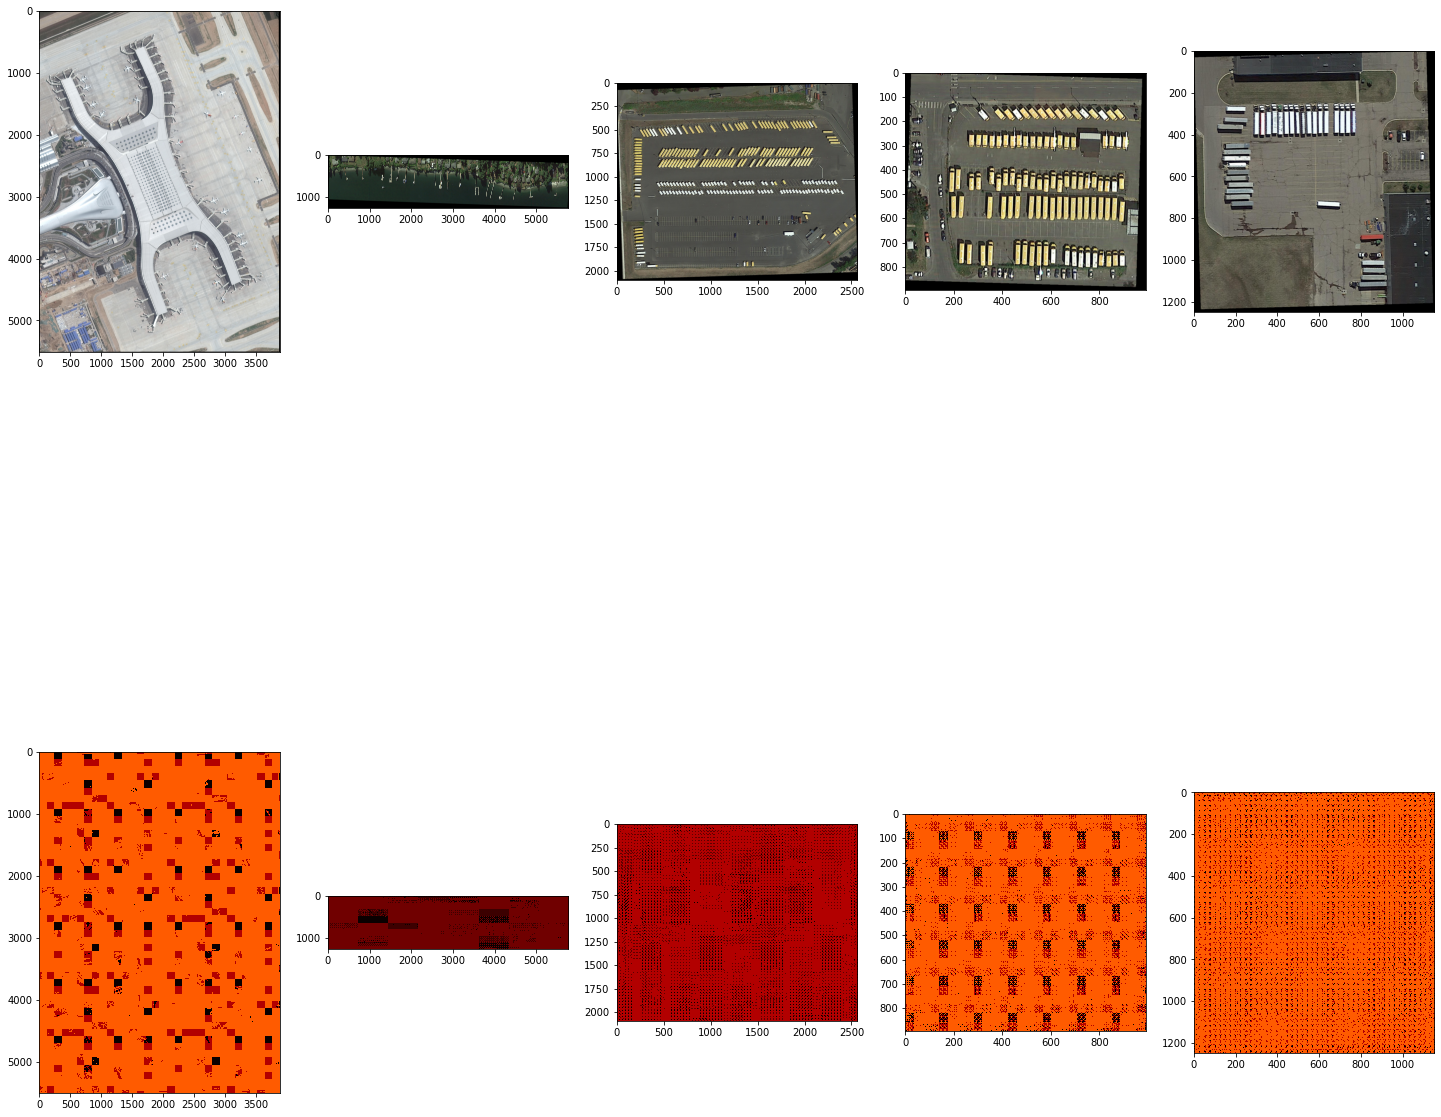

In [7]:
model = model_builder.build_segmentation_model((None, None, 3), 4, 3, 8, 16)
imgbatch, annotbatch = generator[0]
fig = plt.figure(figsize=(25, 25))
for i, img in enumerate(imgbatch):
    padded_img = np.zeros(
        (1, (img.shape[0] // 16 + 1) * 16, (img.shape[1] // 16 + 1) * 16, 3)
    )
    padded_img[0, : img.shape[0], : img.shape[1], :] = img
    pred = model.predict(padded_img)
    pred = np.argmax(pred, axis=3)[0]
    fig.add_subplot(2, 5, i + 1)
    plt.imshow(padded_img[0].astype(np.uint8))
    fig.add_subplot(2, 5, i + 6)
    plt.imshow(pred, cmap="hot", interpolation="nearest")

In [10]:
model = tf.keras.models.load_model(".\\ckpts", compile=False, custom_objects={'iou_coef': accuracy.iou_coef})

P0000


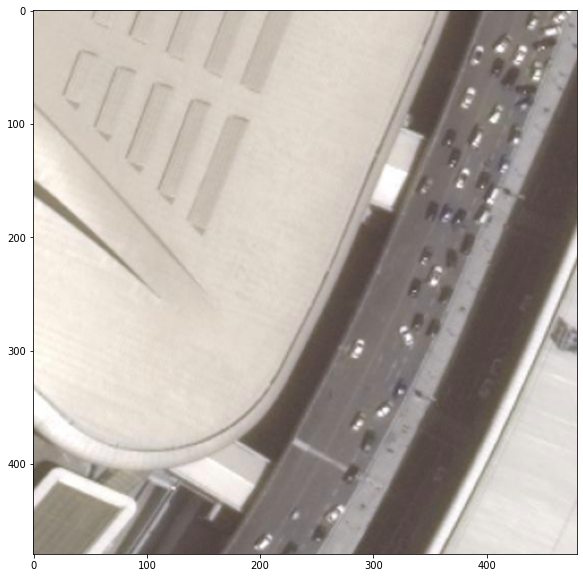

ValueError: Unsupported dtype

In [11]:
seg_generator = SegmentationSequence(
        ".\\data\\train\\images", ".\\data\\train\\annotations", batch_size=1
    )
for i in range(30):
    img, mask = seg_generator[0]

img.shape = (1, 480, 480, 3)
mask.shape = (1, 480, 480, 16)
plt.figure(figsize=(10,10))
plt.imshow(img[0])
pred = model.predict(img)[0]
pred = pred * 255
pred = pred.astype(np.uint8)
fig = plt.figure(figsize=(8,48))
for cnum in range(16):
    fig.add_subplot(16, 2, 2 * cnum + 1)
    plt.imshow(mask[0,:,:,cnum], cmap='hot', interpolation="nearest")
    fig.add_subplot(16, 2, 2 * cnum + 2)
    plt.imshow(pred[:,:,cnum], cmap='hot', interpolation="nearest")

pred_max = np.argmax(pred, axis=2)
fig = plt.figure(figsize=(10,10))
plt.imshow(pred_max, cmap='hot', interpolation="nearest")


In [8]:
tf.keras.backend.clear_session()
del model
gc.collect()

1194704

In [9]:
print(pred[:,:,])

[[[0.013855 0.01017  0.01037  ... 0.00952  0.011734 0.008675]
  [0.01799  0.013855 0.01364  ... 0.01229  0.01547  0.01094 ]
  [0.02153  0.01704  0.01646  ... 0.01466  0.01875  0.01282 ]
  ...
  [0.01901  0.01541  0.0145   ... 0.013016 0.01666  0.01151 ]
  [0.01616  0.01263  0.01219  ... 0.01107  0.01396  0.00997 ]
  [0.01282  0.00956  0.0096   ... 0.00885  0.0109   0.008125]]

 [[0.01819  0.01406  0.013855 ... 0.01243  0.01573  0.01107 ]
  [0.0275   0.02354  0.02129  ... 0.01869  0.02455  0.01604 ]
  [0.03436  0.03198  0.02696  ... 0.02338  0.03156  0.0196  ]
  ...
  [0.02795  0.02737  0.02194  ... 0.0192   0.02591  0.0164  ]
  [0.02153  0.01935  0.01666  ... 0.014786 0.01938  0.012924]
  [0.0158   0.01248  0.011955 ... 0.0109   0.01369  0.00979 ]]

 [[0.02216  0.01764  0.0169   ... 0.01507  0.01935  0.01317 ]
  [0.03436  0.03235  0.02707  ... 0.02342  0.03162  0.0196  ]
  [0.04346  0.04648  0.03488  ... 0.02977  0.04153  0.02434 ]
  ...
  [0.03516  0.0397   0.02821  ... 0.02428  0.033